In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.subplots as sub
import dash
from dash import dcc, html, Output, Input, State
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, top_k_accuracy_score
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.trial import TrialState

from functools import partial
import random
import os
import itertools
from PIL import Image
from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torchvision.models import vgg16_bn, resnet50, resnet18, efficientnet_b0, densenet121, ResNet50_Weights, ResNet18_Weights, VGG16_BN_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
from torchvision.utils import make_grid, draw_bounding_boxes, draw_segmentation_masks, draw_keypoints
from torchvision import datasets
from torchvision.transforms import ToTensor, v2, ToPILImage
from torchvision.io import decode_image

from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler, autocast

from transformers import ViTForImageClassification, ViTImageProcessor, AutoModelForImageClassification, AutoImageProcessor, Trainer, TrainingArguments
from huggingface_hub import snapshot_download, hf_hub_download
import socket
import json
import sys
import io
import base64

In [10]:
# Get the absolute path to the src folder
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if os.path.isdir(src_path) and src_path not in sys.path:
    sys.path.append(src_path)

In [11]:
from hyperopt import get_model, objective


In [12]:
from data_utils import FGVCAircraftDataset, get_datasets, get_loaders, get_raw
from models import CAPResNet, SEEffNet, LabelSmoothingCrossEntropy, FocalLoss
from aircraft_utils import train_one_epoch, evaluate, visualize_predictions

In [13]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

In [14]:
get_raw()

WindowsPath('C:/Users/chihp/Capstone/FGVCAircraft/fgvc-aircraft-2013b/data')

In [7]:
study = optuna.create_study(study_name="Finest_FGVCAircraft_Variant", direction='maximize', 
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5, interval_steps=3))
study.optimize(objective, timeout=None, n_jobs=1, n_trials=30, gc_after_trial=False, show_progress_bar=True)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



[I 2025-08-12 07:22:06,885] A new study created in memory with name: Finest_FGVCAircraft_Variant


  0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.4848, Train Acc: 0.0087
Val Loss: 4.4815, Val Acc: 0.0093
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.4812, Train Acc: 0.0075
Val Loss: 4.4818, Val Acc: 0.0081
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.4840, Train Acc: 0.0057
Val Loss: 4.4813, Val Acc: 0.0072
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.4835, Train Acc: 0.0135
Val Loss: 4.4812, Val Acc: 0.0084
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.4822, Train Acc: 0.0066
Val Loss: 4.4812, Val Acc: 0.0081
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.4813, Train Acc: 0.0114
Val Loss: 4.4811, Val Acc: 0.0087
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.4811, Train Acc: 0.0081
Val Loss: 4.4808, Val Acc: 0.0075
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.4829, Train Acc: 0.0081
Val Loss: 4.4806, Val Acc: 0.0093
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.4813, Train Acc: 0.0135
Val Loss: 4.4808, Val Acc: 0.0081
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.4823, Train Acc: 0.0093
Val Loss: 4.4800, Val Acc: 0.0087
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.4812, Train Acc: 0.0096
Val Loss: 4.4811, Val Acc: 0.0096
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 4.4841, Train Acc: 0.0084
Val Loss: 4.4808, Val Acc: 0.0087
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 4.4817, Train Acc: 0.0099
Val Loss: 4.4807, Val Acc: 0.0075
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 4.4824, Train Acc: 0.0114
Val Loss: 4.4806, Val Acc: 0.0084
⚠️ No improvement for 4 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 4.4826, Train Acc: 0.0099
Val Loss: 4.4805, Val Acc: 0.0081
⚠️ No improvement for 5 epoch(s).
⏹️ Early stopping triggered.
[I 2025-08-12 07:51:40,942] Trial 0 finished with value: 0.008100810081008101 and parameters: {'lr': 0.00023425900985431762, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.0016021484278164089, 'dropout_rate': 0.49011838071568115, 'backbone': 'ResNet50_CAP', 'scheduler': 'ReduceLROnPlateau', 'criterion': 'Focal', 'gamma': 2.7344435292159313}. Best is trial 0 with value: 0.008100810081008101.


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 5.2886, Train Acc: 0.0087
Val Loss: 4.6081, Val Acc: 0.0099
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.6615, Train Acc: 0.0072
Val Loss: 4.6213, Val Acc: 0.0105
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.6326, Train Acc: 0.0087
Val Loss: 9.8367, Val Acc: 0.0099
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.6203, Train Acc: 0.0087
Val Loss: 4.6056, Val Acc: 0.0099
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.6153, Train Acc: 0.0066
Val Loss: 4.6558, Val Acc: 0.0099
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.6086, Train Acc: 0.0099
Val Loss: 4.6054, Val Acc: 0.0093
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.6065, Train Acc: 0.0084
Val Loss: 4.6054, Val Acc: 0.0099
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.6023, Train Acc: 0.0096
Val Loss: 4.6054, Val Acc: 0.0099
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.6005, Train Acc: 0.0090
Val Loss: 4.6009, Val Acc: 0.0102
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.6022, Train Acc: 0.0108
Val Loss: 4.5920, Val Acc: 0.0156
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.5876, Train Acc: 0.0153
Val Loss: 4.5871, Val Acc: 0.0171
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 4.5833, Train Acc: 0.0153
Val Loss: 4.5807, Val Acc: 0.0162
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 4.5802, Train Acc: 0.0132
Val Loss: 4.5973, Val Acc: 0.0150
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 4.5843, Train Acc: 0.0123
Val Loss: 4.5736, Val Acc: 0.0150
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 4.5818, Train Acc: 0.0165
Val Loss: 4.6853, Val Acc: 0.0147
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 4.5739, Train Acc: 0.0204
Val Loss: 4.6012, Val Acc: 0.0117
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 4.5656, Train Acc: 0.0171
Val Loss: 4.5681, Val Acc: 0.0147
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 4.5673, Train Acc: 0.0186
Val Loss: 4.5620, Val Acc: 0.0165
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 4.5639, Train Acc: 0.0186
Val Loss: 4.5689, Val Acc: 0.0162
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 4.5617, Train Acc: 0.0162
Val Loss: 4.6044, Val Acc: 0.0111
⚠️ No improvement for 2 epoch(s).
[I 2025-08-12 08:31:24,912] Trial 1 finished with value: 0.0111011101110111 and parameters: {'lr': 0.006643203419555479, 'batch_size': 32, 'optimizer': 'RMSprop', 'weight_decay': 0.0022969932764354004, 'dropout_rate': 0.22659046707921232, 'backbone': 'ResNet50_CAP', 'scheduler': 'StepLR', 'criterion': 'CrossEntropy', 'label_smoothing': 0.04807593750692523}. Best is trial 1 with value: 0.0111011101110111.


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5116, Train Acc: 0.0120
Val Loss: 4.5109, Val Acc: 0.0075
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5127, Train Acc: 0.0090
Val Loss: 4.5108, Val Acc: 0.0075
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.5117, Train Acc: 0.0072
Val Loss: 4.5109, Val Acc: 0.0078
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.5102, Train Acc: 0.0084
Val Loss: 4.5107, Val Acc: 0.0075
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.5122, Train Acc: 0.0084
Val Loss: 4.5106, Val Acc: 0.0093
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.5109, Train Acc: 0.0057
Val Loss: 4.5105, Val Acc: 0.0084
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.5108, Train Acc: 0.0102
Val Loss: 4.5107, Val Acc: 0.0072
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.5100, Train Acc: 0.0120
Val Loss: 4.5110, Val Acc: 0.0072
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.5135, Train Acc: 0.0090
Val Loss: 4.5106, Val Acc: 0.0096
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.5109, Train Acc: 0.0096
Val Loss: 4.5105, Val Acc: 0.0099
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.5125, Train Acc: 0.0126
Val Loss: 4.5106, Val Acc: 0.0078
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 4.5095, Train Acc: 0.0081
Val Loss: 4.5107, Val Acc: 0.0087
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 4.5098, Train Acc: 0.0114
Val Loss: 4.5104, Val Acc: 0.0093
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 4.5114, Train Acc: 0.0108
Val Loss: 4.5107, Val Acc: 0.0096
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 4.5108, Train Acc: 0.0096
Val Loss: 4.5105, Val Acc: 0.0078
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 4.5126, Train Acc: 0.0078
Val Loss: 4.5105, Val Acc: 0.0078
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 4.5115, Train Acc: 0.0075
Val Loss: 4.5106, Val Acc: 0.0075
⚠️ No improvement for 4 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 4.5122, Train Acc: 0.0111
Val Loss: 4.5105, Val Acc: 0.0102
⚠️ No improvement for 5 epoch(s).
⏹️ Early stopping triggered.
[I 2025-08-12 09:08:09,488] Trial 2 finished with value: 0.0102010201020102 and parameters: {'lr': 9.055507382684266e-05, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 0.0016476719482305736, 'dropout_rate': 0.29455139083670057, 'backbone': 'ResNet50_CAP', 'scheduler': 'ReduceLROnPlateau', 'criterion': 'Focal', 'gamma': 2.071648133264708}. Best is trial 1 with value: 0.0111011101110111.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.9345, Train Acc: 0.0075
Val Loss: 5.0880, Val Acc: 0.0063
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.6953, Train Acc: 0.0054
Val Loss: 40.9274, Val Acc: 0.0138
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.7050, Train Acc: 0.0084
Val Loss: 5.5783, Val Acc: 0.0099
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.6828, Train Acc: 0.0090
Val Loss: 5.4240, Val Acc: 0.0084
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.6653, Train Acc: 0.0090
Val Loss: 4.8420, Val Acc: 0.0093
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.6449, Train Acc: 0.0102
Val Loss: 4.6249, Val Acc: 0.0102
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.6410, Train Acc: 0.0117
Val Loss: 7.0975, Val Acc: 0.0093
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.6384, Train Acc: 0.0069
Val Loss: 19.0274, Val Acc: 0.0099
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.6318, Train Acc: 0.0099
Val Loss: 4.8455, Val Acc: 0.0102
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.6296, Train Acc: 0.0087
Val Loss: 4.6737, Val Acc: 0.0099
⚠️ No improvement for 4 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.6141, Train Acc: 0.0087
Val Loss: 4.5992, Val Acc: 0.0144
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 4.5964, Train Acc: 0.0162
Val Loss: 4.5871, Val Acc: 0.0204
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 4.5672, Train Acc: 0.0180
Val Loss: 4.5376, Val Acc: 0.0213
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 4.5487, Train Acc: 0.0177
Val Loss: 4.5380, Val Acc: 0.0255
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 4.5342, Train Acc: 0.0207
Val Loss: 4.5115, Val Acc: 0.0255
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 4.5210, Train Acc: 0.0210
Val Loss: 4.4999, Val Acc: 0.0297
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 4.5116, Train Acc: 0.0279
Val Loss: 4.4962, Val Acc: 0.0279
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 4.5097, Train Acc: 0.0261
Val Loss: 4.4757, Val Acc: 0.0300
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 4.4852, Train Acc: 0.0282
Val Loss: 4.4562, Val Acc: 0.0330
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 4.4717, Train Acc: 0.0264
Val Loss: 4.4665, Val Acc: 0.0348
⚠️ No improvement for 1 epoch(s).
[I 2025-08-12 09:51:41,481] Trial 3 finished with value: 0.0348034803480348 and parameters: {'lr': 0.006609124233662402, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 4.189958982565816e-05, 'dropout_rate': 0.3505836778785084, 'backbone': 'ResNet50_CAP', 'scheduler': 'ReduceLROnPlateau', 'criterion': 'LabelSmoothing', 'smoothing': 0.19956042479899072}. Best is trial 3 with value: 0.0348034803480348.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.6069, Train Acc: 0.0144
Val Loss: 4.5790, Val Acc: 0.0279
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5716, Train Acc: 0.0312
Val Loss: 4.5441, Val Acc: 0.0525
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.5297, Train Acc: 0.0546
Val Loss: 4.4868, Val Acc: 0.0813
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.4551, Train Acc: 0.0696
Val Loss: 4.3640, Val Acc: 0.0981
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.3672, Train Acc: 0.0879
Val Loss: 4.2529, Val Acc: 0.1203
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.2766, Train Acc: 0.1107
Val Loss: 4.1381, Val Acc: 0.1362
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.1834, Train Acc: 0.1272
Val Loss: 4.0484, Val Acc: 0.1599
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.1038, Train Acc: 0.1488
Val Loss: 3.9348, Val Acc: 0.1935
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.0240, Train Acc: 0.1725
Val Loss: 3.8593, Val Acc: 0.2151
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 3.9234, Train Acc: 0.1965
Val Loss: 3.7512, Val Acc: 0.2331
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 3.8465, Train Acc: 0.2109
Val Loss: 3.6547, Val Acc: 0.2562
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 3.7763, Train Acc: 0.2232
Val Loss: 3.6046, Val Acc: 0.2616
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 3.6666, Train Acc: 0.2507
Val Loss: 3.4937, Val Acc: 0.2877
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 3.5860, Train Acc: 0.2678
Val Loss: 3.4124, Val Acc: 0.3111
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 3.5217, Train Acc: 0.2774
Val Loss: 3.3525, Val Acc: 0.3156
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 3.4488, Train Acc: 0.3194
Val Loss: 3.2637, Val Acc: 0.3387
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 3.3760, Train Acc: 0.3233
Val Loss: 3.1973, Val Acc: 0.3600
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 3.3213, Train Acc: 0.3347
Val Loss: 3.1086, Val Acc: 0.3810
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 3.2569, Train Acc: 0.3485
Val Loss: 3.0673, Val Acc: 0.3960
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 3.1978, Train Acc: 0.3692
Val Loss: 3.0293, Val Acc: 0.3972
✅ Model improved. Saving...
[I 2025-08-12 10:30:46,443] Trial 4 finished with value: 0.39723972397239726 and parameters: {'lr': 2.877528072533932e-05, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 3.0318681659465976e-06, 'dropout_rate': 0.2591650708011861, 'backbone': 'EffNet_SE', 'scheduler': 'ReduceLROnPlateau', 'criterion': 'LabelSmoothing', 'smoothing': 0.169748437798598}. Best is trial 4 with value: 0.39723972397239726.


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5998, Train Acc: 0.0174
Val Loss: 4.5825, Val Acc: 0.0237
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5792, Train Acc: 0.0270
Val Loss: 4.5596, Val Acc: 0.0441
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.5565, Train Acc: 0.0390
Val Loss: 4.5321, Val Acc: 0.0603
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.5302, Train Acc: 0.0564
Val Loss: 4.4956, Val Acc: 0.0783
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.4927, Train Acc: 0.0711
Val Loss: 4.4358, Val Acc: 0.0924
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.4392, Train Acc: 0.0825
Val Loss: 4.3610, Val Acc: 0.1131
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.3660, Train Acc: 0.1005
Val Loss: 4.2558, Val Acc: 0.1233
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.2828, Train Acc: 0.1119
Val Loss: 4.1658, Val Acc: 0.1302
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.2060, Train Acc: 0.1311
Val Loss: 4.0650, Val Acc: 0.1494
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.1257, Train Acc: 0.1353
Val Loss: 3.9624, Val Acc: 0.1653
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.0419, Train Acc: 0.1530
Val Loss: 3.8948, Val Acc: 0.1848
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 3.9684, Train Acc: 0.1653
Val Loss: 3.7852, Val Acc: 0.2007
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 3.8878, Train Acc: 0.1872
Val Loss: 3.7459, Val Acc: 0.2130
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 3.8011, Train Acc: 0.1971
Val Loss: 3.6224, Val Acc: 0.2283
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 3.7091, Train Acc: 0.2196
Val Loss: 3.5404, Val Acc: 0.2457
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 3.6146, Train Acc: 0.2373
Val Loss: 3.4381, Val Acc: 0.2640
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 3.5429, Train Acc: 0.2451
Val Loss: 3.3569, Val Acc: 0.2835
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 3.4531, Train Acc: 0.2612
Val Loss: 3.2922, Val Acc: 0.3042
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 3.3775, Train Acc: 0.2876
Val Loss: 3.1892, Val Acc: 0.3228
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 3.3100, Train Acc: 0.3065
Val Loss: 3.1260, Val Acc: 0.3309
✅ Model improved. Saving...
[I 2025-08-12 11:09:51,382] Trial 5 finished with value: 0.3309330933093309 and parameters: {'lr': 2.5849994916983644e-05, 'batch_size': 32, 'optimizer': 'RMSprop', 'weight_decay': 0.0042843730954991764, 'dropout_rate': 0.2560819454382125, 'backbone': 'EffNet_SE', 'scheduler': 'ReduceLROnPlateau', 'criterion': 'CrossEntropy', 'label_smoothing': 0.11218238564658503}. Best is trial 4 with value: 0.39723972397239726.


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.4778, Train Acc: 0.0339
Val Loss: 4.2302, Val Acc: 0.0543
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.0045, Train Acc: 0.1044
Val Loss: 3.6623, Val Acc: 0.1449
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 3.6276, Train Acc: 0.1689
Val Loss: 3.5680, Val Acc: 0.1695
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.3637, Train Acc: 0.2385
Val Loss: 3.2763, Val Acc: 0.2547
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.1579, Train Acc: 0.2867
Val Loss: 3.1936, Val Acc: 0.2745
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 2.9221, Train Acc: 0.3704
Val Loss: 2.8282, Val Acc: 0.3879
[I 2025-08-12 11:21:43,364] Trial 6 pruned. 


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.4784, Train Acc: 0.0132
Val Loss: 4.4723, Val Acc: 0.0123
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.4692, Train Acc: 0.0162
Val Loss: 4.4616, Val Acc: 0.0192
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.4535, Train Acc: 0.0225
Val Loss: 4.4363, Val Acc: 0.0405
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.4225, Train Acc: 0.0318
Val Loss: 4.3833, Val Acc: 0.0630
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.3449, Train Acc: 0.0567
Val Loss: 4.1994, Val Acc: 0.0699
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.1622, Train Acc: 0.0705
Val Loss: 3.9913, Val Acc: 0.1152
[I 2025-08-12 11:34:09,143] Trial 7 pruned. 


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.6102, Train Acc: 0.0102
Val Loss: 4.6073, Val Acc: 0.0123
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.6058, Train Acc: 0.0108
Val Loss: 4.6052, Val Acc: 0.0120
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.6038, Train Acc: 0.0108
Val Loss: 4.6022, Val Acc: 0.0147
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.6011, Train Acc: 0.0180
Val Loss: 4.5984, Val Acc: 0.0135
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.5974, Train Acc: 0.0156
Val Loss: 4.5952, Val Acc: 0.0165
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.5961, Train Acc: 0.0147
Val Loss: 4.5941, Val Acc: 0.0156
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.5966, Train Acc: 0.0132
Val Loss: 4.5916, Val Acc: 0.0162
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.5934, Train Acc: 0.0180
Val Loss: 4.5897, Val Acc: 0.0177
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.5908, Train Acc: 0.0168
Val Loss: 4.5883, Val Acc: 0.0180
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.5900, Train Acc: 0.0165
Val Loss: 4.5870, Val Acc: 0.0213
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.5880, Train Acc: 0.0153
Val Loss: 4.5866, Val Acc: 0.0219
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 4.5873, Train Acc: 0.0255
Val Loss: 4.5852, Val Acc: 0.0201
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 4.5869, Train Acc: 0.0255
Val Loss: 4.5844, Val Acc: 0.0219
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 4.5867, Train Acc: 0.0183
Val Loss: 4.5839, Val Acc: 0.0207
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 4.5849, Train Acc: 0.0219
Val Loss: 4.5826, Val Acc: 0.0204
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 4.5840, Train Acc: 0.0240
Val Loss: 4.5829, Val Acc: 0.0192
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 4.5857, Train Acc: 0.0192
Val Loss: 4.5818, Val Acc: 0.0228
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 4.5837, Train Acc: 0.0234
Val Loss: 4.5819, Val Acc: 0.0213
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 4.5841, Train Acc: 0.0219
Val Loss: 4.5809, Val Acc: 0.0228
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 4.5825, Train Acc: 0.0222
Val Loss: 4.5809, Val Acc: 0.0222
⚠️ No improvement for 1 epoch(s).
[I 2025-08-12 12:14:23,473] Trial 8 finished with value: 0.0222022202220222 and parameters: {'lr': 0.001830794563846334, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.00039165923702098773, 'dropout_rate': 0.10122515557972522, 'backbone': 'EffNet_SE', 'scheduler': 'StepLR', 'criterion': 'LabelSmoothing', 'smoothing': 0.16842206854503083}. Best is trial 4 with value: 0.39723972397239726.


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5277, Train Acc: 0.0105
Val Loss: 4.5265, Val Acc: 0.0087
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5292, Train Acc: 0.0093
Val Loss: 4.5279, Val Acc: 0.0096
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.5308, Train Acc: 0.0120
Val Loss: 4.5266, Val Acc: 0.0084
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.5277, Train Acc: 0.0099
Val Loss: 4.5272, Val Acc: 0.0090
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.5273, Train Acc: 0.0102
Val Loss: 4.5262, Val Acc: 0.0081
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.5266, Train Acc: 0.0129
Val Loss: 4.5272, Val Acc: 0.0096
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.5272, Train Acc: 0.0111
Val Loss: 4.5272, Val Acc: 0.0099
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.5284, Train Acc: 0.0120
Val Loss: 4.5272, Val Acc: 0.0081
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.5332, Train Acc: 0.0075
Val Loss: 4.5267, Val Acc: 0.0102
⚠️ No improvement for 4 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.5295, Train Acc: 0.0093
Val Loss: 4.5268, Val Acc: 0.0087
⚠️ No improvement for 5 epoch(s).
⏹️ Early stopping triggered.
[I 2025-08-12 12:34:03,666] Trial 9 finished with value: 0.0087008700870087 and parameters: {'lr': 2.7299744502411625e-05, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 0.0017796427729275454, 'dropout_rate': 0.4167500429094674, 'backbone': 'EffNet_SE', 'scheduler': 'CosineAnnealingLR', 'criterion': 'Focal', 'gamma': 1.7620762255537317}. Best is trial 4 with value: 0.39723972397239726.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5797, Train Acc: 0.0213
Val Loss: 4.4696, Val Acc: 0.0687
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.3074, Train Acc: 0.0873
Val Loss: 3.9244, Val Acc: 0.1518
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 3.7964, Train Acc: 0.1614
Val Loss: 3.3134, Val Acc: 0.2382
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.3565, Train Acc: 0.2340
Val Loss: 2.9402, Val Acc: 0.3120
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.0937, Train Acc: 0.2867
Val Loss: 2.7134, Val Acc: 0.3801
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 2.8521, Train Acc: 0.3503
Val Loss: 2.5536, Val Acc: 0.4059
[I 2025-08-12 12:46:12,349] Trial 10 pruned. 


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.6061, Train Acc: 0.0096
Val Loss: 4.5961, Val Acc: 0.0126
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5948, Train Acc: 0.0159
Val Loss: 4.5862, Val Acc: 0.0162
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.5848, Train Acc: 0.0234
Val Loss: 4.5756, Val Acc: 0.0240
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.5792, Train Acc: 0.0243
Val Loss: 4.5632, Val Acc: 0.0300
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.5635, Train Acc: 0.0378
Val Loss: 4.5488, Val Acc: 0.0408
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.5526, Train Acc: 0.0324
Val Loss: 4.5309, Val Acc: 0.0489
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.5345, Train Acc: 0.0486
Val Loss: 4.5117, Val Acc: 0.0627
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.5160, Train Acc: 0.0576
Val Loss: 4.4834, Val Acc: 0.0732
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.4943, Train Acc: 0.0627
Val Loss: 4.4564, Val Acc: 0.0888
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.4745, Train Acc: 0.0735
Val Loss: 4.4292, Val Acc: 0.1023
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.4367, Train Acc: 0.0873
Val Loss: 4.3950, Val Acc: 0.1017
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 4.4090, Train Acc: 0.0930
Val Loss: 4.3413, Val Acc: 0.1101
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 4.3725, Train Acc: 0.0996
Val Loss: 4.2935, Val Acc: 0.1200
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 4.3299, Train Acc: 0.1044
Val Loss: 4.2289, Val Acc: 0.1230
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 4.2869, Train Acc: 0.1077
Val Loss: 4.1759, Val Acc: 0.1239
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 4.2301, Train Acc: 0.1161
Val Loss: 4.1065, Val Acc: 0.1401
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 4.1714, Train Acc: 0.1197
Val Loss: 4.0458, Val Acc: 0.1509
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 4.1274, Train Acc: 0.1275
Val Loss: 3.9774, Val Acc: 0.1518
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 4.0687, Train Acc: 0.1506
Val Loss: 3.9253, Val Acc: 0.1647
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 4.0267, Train Acc: 0.1383
Val Loss: 3.8769, Val Acc: 0.1692
✅ Model improved. Saving...
[I 2025-08-12 13:24:40,563] Trial 11 finished with value: 0.1692169216921692 and parameters: {'lr': 1.0582552753209869e-05, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 8.970436075592283e-06, 'dropout_rate': 0.2686794514068889, 'backbone': 'EffNet_SE', 'scheduler': 'ReduceLROnPlateau', 'criterion': 'CrossEntropy', 'label_smoothing': 0.11153488149791854}. Best is trial 4 with value: 0.39723972397239726.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.6017, Train Acc: 0.0138
Val Loss: 4.5667, Val Acc: 0.0261
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5466, Train Acc: 0.0423
Val Loss: 4.4916, Val Acc: 0.0717
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.4563, Train Acc: 0.0756
Val Loss: 4.3277, Val Acc: 0.1098
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.3010, Train Acc: 0.1080
Val Loss: 4.1035, Val Acc: 0.1548
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.1259, Train Acc: 0.1326
Val Loss: 3.9033, Val Acc: 0.1803
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 3.9616, Train Acc: 0.1776
Val Loss: 3.7608, Val Acc: 0.2262
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 3.7998, Train Acc: 0.2088
Val Loss: 3.5740, Val Acc: 0.2682
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 3.6693, Train Acc: 0.2528
Val Loss: 3.4300, Val Acc: 0.2946
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 3.5412, Train Acc: 0.2876
Val Loss: 3.2988, Val Acc: 0.3363
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 3.4393, Train Acc: 0.3260
Val Loss: 3.1866, Val Acc: 0.3699
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 3.3385, Train Acc: 0.3515
Val Loss: 3.1159, Val Acc: 0.3912
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 3.2472, Train Acc: 0.3857
Val Loss: 3.0333, Val Acc: 0.4161
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 3.1706, Train Acc: 0.4076
Val Loss: 3.0055, Val Acc: 0.4281
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 3.1227, Train Acc: 0.4280
Val Loss: 2.9914, Val Acc: 0.4272
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 3.0640, Train Acc: 0.4427
Val Loss: 2.9355, Val Acc: 0.4560
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 3.0102, Train Acc: 0.4613
Val Loss: 2.8851, Val Acc: 0.4632
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 2.9683, Train Acc: 0.4823
Val Loss: 2.8210, Val Acc: 0.4956
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 2.9265, Train Acc: 0.5039
Val Loss: 2.8026, Val Acc: 0.4989
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 2.8800, Train Acc: 0.5123
Val Loss: 2.7855, Val Acc: 0.5002
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 2.8281, Train Acc: 0.5234
Val Loss: 2.7337, Val Acc: 0.5161
✅ Model improved. Saving...
[I 2025-08-12 14:04:23,450] Trial 12 finished with value: 0.5160516051605161 and parameters: {'lr': 4.6085737029655436e-05, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 0.00875643293365455, 'dropout_rate': 0.2118836852413221, 'backbone': 'EffNet_SE', 'scheduler': 'ReduceLROnPlateau', 'criterion': 'CrossEntropy', 'label_smoothing': 0.1999754474927723}. Best is trial 12 with value: 0.5160516051605161.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5808, Train Acc: 0.0261
Val Loss: 4.5050, Val Acc: 0.0687
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.4168, Train Acc: 0.0765
Val Loss: 4.1759, Val Acc: 0.1131
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.0906, Train Acc: 0.1221
Val Loss: 3.7414, Val Acc: 0.1755
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.7721, Train Acc: 0.1764
Val Loss: 3.4682, Val Acc: 0.2346
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.5309, Train Acc: 0.2331
Val Loss: 3.1960, Val Acc: 0.3024
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 3.3437, Train Acc: 0.2807
Val Loss: 3.0392, Val Acc: 0.3471
[I 2025-08-12 14:16:23,677] Trial 13 pruned. 


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.4204, Train Acc: 0.0522
Val Loss: 4.0494, Val Acc: 0.0942
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.0235, Train Acc: 0.1014
Val Loss: 3.9229, Val Acc: 0.1470
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 3.8603, Train Acc: 0.1359
Val Loss: 3.7117, Val Acc: 0.1848
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.7310, Train Acc: 0.1764
Val Loss: 3.7621, Val Acc: 0.1755
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.7172, Train Acc: 0.1731
Val Loss: 3.6697, Val Acc: 0.2142
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 3.6691, Train Acc: 0.1848
Val Loss: 3.7433, Val Acc: 0.1692
[I 2025-08-12 14:28:26,965] Trial 14 pruned. 


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5858, Train Acc: 0.0267
Val Loss: 4.5232, Val Acc: 0.0645
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.4806, Train Acc: 0.0648
Val Loss: 4.3320, Val Acc: 0.1089
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.2986, Train Acc: 0.1068
Val Loss: 4.0620, Val Acc: 0.1560
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.1053, Train Acc: 0.1479
Val Loss: 3.8593, Val Acc: 0.2085
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.9326, Train Acc: 0.1890
Val Loss: 3.6532, Val Acc: 0.2256
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 3.7526, Train Acc: 0.2208
Val Loss: 3.5033, Val Acc: 0.2580
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 3.6162, Train Acc: 0.2430
Val Loss: 3.3718, Val Acc: 0.2937
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 3.4630, Train Acc: 0.2861
Val Loss: 3.2649, Val Acc: 0.3177
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 3.3657, Train Acc: 0.3065
Val Loss: 3.1600, Val Acc: 0.3321
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 3.3082, Train Acc: 0.3272
Val Loss: 3.0981, Val Acc: 0.3543
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 3.2241, Train Acc: 0.3395
Val Loss: 3.0469, Val Acc: 0.3609
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 3.1708, Train Acc: 0.3620
Val Loss: 2.9713, Val Acc: 0.3861
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 3.1310, Train Acc: 0.3767
Val Loss: 2.9483, Val Acc: 0.3915
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 3.0826, Train Acc: 0.3842
Val Loss: 2.9382, Val Acc: 0.3921
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 3.0842, Train Acc: 0.3860
Val Loss: 2.9302, Val Acc: 0.3891
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 3.0530, Train Acc: 0.3902
Val Loss: 2.8925, Val Acc: 0.4071
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 3.0609, Train Acc: 0.3899
Val Loss: 2.8821, Val Acc: 0.4122
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 3.0434, Train Acc: 0.3995
Val Loss: 2.8697, Val Acc: 0.4155
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 3.0204, Train Acc: 0.4136
Val Loss: 2.8791, Val Acc: 0.4164
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 3.0215, Train Acc: 0.4076
Val Loss: 2.8846, Val Acc: 0.4101
⚠️ No improvement for 2 epoch(s).
[I 2025-08-12 15:08:42,752] Trial 15 finished with value: 0.41014101410141013 and parameters: {'lr': 4.7822859853694306e-05, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 5.624390856910442e-06, 'dropout_rate': 0.13004490548510417, 'backbone': 'EffNet_SE', 'scheduler': 'CosineAnnealingLR', 'criterion': 'LabelSmoothing', 'smoothing': 0.14204060281299233}. Best is trial 12 with value: 0.5160516051605161.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5890, Train Acc: 0.0207
Val Loss: 4.5288, Val Acc: 0.0522
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.4742, Train Acc: 0.0606
Val Loss: 4.3068, Val Acc: 0.1119
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.1810, Train Acc: 0.1116
Val Loss: 3.8453, Val Acc: 0.1626
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.8079, Train Acc: 0.1698
Val Loss: 3.4880, Val Acc: 0.2400
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.5390, Train Acc: 0.2286
Val Loss: 3.2060, Val Acc: 0.2913
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 3.3280, Train Acc: 0.2741
Val Loss: 3.0232, Val Acc: 0.3378
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 3.1387, Train Acc: 0.3194
Val Loss: 2.8966, Val Acc: 0.3645
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 3.0065, Train Acc: 0.3638
Val Loss: 2.7817, Val Acc: 0.3972
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 2.9131, Train Acc: 0.3983
Val Loss: 2.6972, Val Acc: 0.4104
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 2.8545, Train Acc: 0.4100
Val Loss: 2.6461, Val Acc: 0.4290
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 2.7724, Train Acc: 0.4388
Val Loss: 2.5972, Val Acc: 0.4476
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 2.7186, Train Acc: 0.4520
Val Loss: 2.5965, Val Acc: 0.4311
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 2.6627, Train Acc: 0.4760
Val Loss: 2.5365, Val Acc: 0.4551
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 2.6307, Train Acc: 0.4913
Val Loss: 2.5388, Val Acc: 0.4584
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 2.6182, Train Acc: 0.4775
Val Loss: 2.5029, Val Acc: 0.4611
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 2.6007, Train Acc: 0.4913
Val Loss: 2.4766, Val Acc: 0.4758
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 2.5746, Train Acc: 0.5126
Val Loss: 2.4807, Val Acc: 0.4707
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 2.5590, Train Acc: 0.5078
Val Loss: 2.4755, Val Acc: 0.4686
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 2.5631, Train Acc: 0.5096
Val Loss: 2.4714, Val Acc: 0.4707
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 2.5518, Train Acc: 0.5156
Val Loss: 2.4778, Val Acc: 0.4767
⚠️ No improvement for 1 epoch(s).
[I 2025-08-12 15:48:48,783] Trial 16 finished with value: 0.47674767476747676 and parameters: {'lr': 6.374766241559396e-05, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 6.164849016351983e-05, 'dropout_rate': 0.11065030400414952, 'backbone': 'EffNet_SE', 'scheduler': 'CosineAnnealingLR', 'criterion': 'LabelSmoothing', 'smoothing': 0.11293744762348336}. Best is trial 12 with value: 0.5160516051605161.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.4671, Train Acc: 0.0390
Val Loss: 3.9467, Val Acc: 0.1107
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 3.6688, Train Acc: 0.1485
Val Loss: 2.9516, Val Acc: 0.2418
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 2.9625, Train Acc: 0.2454
Val Loss: 2.4101, Val Acc: 0.3492
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 2.5165, Train Acc: 0.3455
Val Loss: 2.1275, Val Acc: 0.3909
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 2.2299, Train Acc: 0.4013
Val Loss: 1.8745, Val Acc: 0.4674
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 2.0343, Train Acc: 0.4514
Val Loss: 1.8237, Val Acc: 0.4779
[I 2025-08-12 16:00:53,387] Trial 17 pruned. 


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5519, Train Acc: 0.0315
Val Loss: 4.2874, Val Acc: 0.0972
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.0250, Train Acc: 0.1182
Val Loss: 3.4425, Val Acc: 0.1989
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 3.4189, Train Acc: 0.2175
Val Loss: 2.9012, Val Acc: 0.2952
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 2.9859, Train Acc: 0.3074
Val Loss: 2.6351, Val Acc: 0.3603
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 2.6933, Train Acc: 0.3944
Val Loss: 2.3895, Val Acc: 0.4413
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 2.5404, Train Acc: 0.4373
Val Loss: 2.3152, Val Acc: 0.4485
[I 2025-08-12 16:12:55,821] Trial 18 pruned. 


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.3996, Train Acc: 0.0552
Val Loss: 3.9815, Val Acc: 0.1239
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 3.8356, Train Acc: 0.1512
Val Loss: 3.5182, Val Acc: 0.2316
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 3.4928, Train Acc: 0.2519
Val Loss: 3.4072, Val Acc: 0.2847
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.2733, Train Acc: 0.3188
Val Loss: 3.1273, Val Acc: 0.3648
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.0990, Train Acc: 0.3881
Val Loss: 3.0425, Val Acc: 0.4038
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 2.9604, Train Acc: 0.4382
Val Loss: 2.9490, Val Acc: 0.4356
[I 2025-08-12 16:24:57,573] Trial 19 pruned. 


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.6096, Train Acc: 0.0102
Val Loss: 4.6046, Val Acc: 0.0111
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5977, Train Acc: 0.0150
Val Loss: 4.5951, Val Acc: 0.0129
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.5914, Train Acc: 0.0153
Val Loss: 4.5859, Val Acc: 0.0165
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.5822, Train Acc: 0.0243
Val Loss: 4.5763, Val Acc: 0.0231
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.5721, Train Acc: 0.0231
Val Loss: 4.5631, Val Acc: 0.0285
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.5594, Train Acc: 0.0387
Val Loss: 4.5505, Val Acc: 0.0441
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.5482, Train Acc: 0.0531
Val Loss: 4.5382, Val Acc: 0.0510
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.5388, Train Acc: 0.0465
Val Loss: 4.5236, Val Acc: 0.0597
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.5244, Train Acc: 0.0618
Val Loss: 4.5076, Val Acc: 0.0705
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.5097, Train Acc: 0.0669
Val Loss: 4.4915, Val Acc: 0.0780
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.4979, Train Acc: 0.0759
Val Loss: 4.4761, Val Acc: 0.0864
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 4.4870, Train Acc: 0.0819
Val Loss: 4.4602, Val Acc: 0.0855
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 4.4741, Train Acc: 0.0912
Val Loss: 4.4490, Val Acc: 0.0951
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 4.4650, Train Acc: 0.0903
Val Loss: 4.4418, Val Acc: 0.0918
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 4.4548, Train Acc: 0.0975
Val Loss: 4.4299, Val Acc: 0.0993
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 4.4532, Train Acc: 0.0900
Val Loss: 4.4214, Val Acc: 0.1005
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 4.4404, Train Acc: 0.1002
Val Loss: 4.4168, Val Acc: 0.1038
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 4.4456, Train Acc: 0.0909
Val Loss: 4.4159, Val Acc: 0.0993
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 4.4447, Train Acc: 0.0981
Val Loss: 4.4146, Val Acc: 0.1077
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 4.4385, Train Acc: 0.1014
Val Loss: 4.4138, Val Acc: 0.0999
✅ Model improved. Saving...
[I 2025-08-12 17:05:16,630] Trial 20 finished with value: 0.0999099909990999 and parameters: {'lr': 1.0313812981758534e-05, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 1.875190657549458e-05, 'dropout_rate': 0.15931291631275885, 'backbone': 'EffNet_SE', 'scheduler': 'CosineAnnealingLR', 'criterion': 'CrossEntropy', 'label_smoothing': 0.15376879170449376}. Best is trial 12 with value: 0.5160516051605161.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5858, Train Acc: 0.0249
Val Loss: 4.5085, Val Acc: 0.0687
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.4485, Train Acc: 0.0678
Val Loss: 4.2507, Val Acc: 0.1101
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.2515, Train Acc: 0.1089
Val Loss: 4.0198, Val Acc: 0.1359
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.0671, Train Acc: 0.1440
Val Loss: 3.7978, Val Acc: 0.1869
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.9114, Train Acc: 0.1740
Val Loss: 3.6096, Val Acc: 0.2235
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 3.7305, Train Acc: 0.2244
Val Loss: 3.4935, Val Acc: 0.2571
[I 2025-08-12 17:17:20,784] Trial 21 pruned. 


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5890, Train Acc: 0.0240
Val Loss: 4.5248, Val Acc: 0.0492
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.4886, Train Acc: 0.0537
Val Loss: 4.3430, Val Acc: 0.0951
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.3266, Train Acc: 0.0942
Val Loss: 4.1101, Val Acc: 0.1371
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.1519, Train Acc: 0.1326
Val Loss: 3.8968, Val Acc: 0.1668
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.9898, Train Acc: 0.1602
Val Loss: 3.7347, Val Acc: 0.2013
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 3.8357, Train Acc: 0.1863
Val Loss: 3.6102, Val Acc: 0.2202
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 3.6889, Train Acc: 0.2100
Val Loss: 3.4833, Val Acc: 0.2466
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 3.5596, Train Acc: 0.2496
Val Loss: 3.3308, Val Acc: 0.2664
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 3.4452, Train Acc: 0.2693
Val Loss: 3.2402, Val Acc: 0.2994
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 3.3692, Train Acc: 0.2897
Val Loss: 3.1447, Val Acc: 0.3360
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 3.2881, Train Acc: 0.3164
Val Loss: 3.0817, Val Acc: 0.3462
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 3.2291, Train Acc: 0.3194
Val Loss: 3.0209, Val Acc: 0.3597
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 3.1673, Train Acc: 0.3524
Val Loss: 2.9921, Val Acc: 0.3702
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 3.1428, Train Acc: 0.3503
Val Loss: 2.9438, Val Acc: 0.3765
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 3.1143, Train Acc: 0.3659
Val Loss: 2.9411, Val Acc: 0.3774
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 3.0886, Train Acc: 0.3632
Val Loss: 2.9296, Val Acc: 0.3750
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 3.0555, Train Acc: 0.3743
Val Loss: 2.9044, Val Acc: 0.3816
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 3.0583, Train Acc: 0.3677
Val Loss: 2.8933, Val Acc: 0.3867
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 3.0353, Train Acc: 0.3818
Val Loss: 2.8894, Val Acc: 0.3816
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 3.0405, Train Acc: 0.3818
Val Loss: 2.9115, Val Acc: 0.3795
⚠️ No improvement for 1 epoch(s).
[I 2025-08-12 17:57:43,005] Trial 22 finished with value: 0.3795379537953795 and parameters: {'lr': 4.759728154645597e-05, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 2.8995130576967966e-05, 'dropout_rate': 0.13815449456258988, 'backbone': 'EffNet_SE', 'scheduler': 'CosineAnnealingLR', 'criterion': 'LabelSmoothing', 'smoothing': 0.11757565593926474}. Best is trial 12 with value: 0.5160516051605161.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5561, Train Acc: 0.0288
Val Loss: 4.3302, Val Acc: 0.0984
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.2073, Train Acc: 0.1029
Val Loss: 3.8314, Val Acc: 0.1932
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 3.7906, Train Acc: 0.1812
Val Loss: 3.4009, Val Acc: 0.2628
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.4492, Train Acc: 0.2543
Val Loss: 3.0966, Val Acc: 0.3249
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.2031, Train Acc: 0.3212
Val Loss: 2.9294, Val Acc: 0.3627
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 2.9725, Train Acc: 0.3899
Val Loss: 2.7641, Val Acc: 0.4188
[I 2025-08-12 18:09:52,749] Trial 23 pruned. 


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5924, Train Acc: 0.0156
Val Loss: 4.5501, Val Acc: 0.0363
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5265, Train Acc: 0.0522
Val Loss: 4.4573, Val Acc: 0.0897
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.4172, Train Acc: 0.0873
Val Loss: 4.2717, Val Acc: 0.1077
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.2584, Train Acc: 0.1119
Val Loss: 4.0623, Val Acc: 0.1371
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.0968, Train Acc: 0.1350
Val Loss: 3.8898, Val Acc: 0.1707
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 3.9393, Train Acc: 0.1557
Val Loss: 3.7241, Val Acc: 0.1962
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 3.7864, Train Acc: 0.1857
Val Loss: 3.5673, Val Acc: 0.2226
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 3.6640, Train Acc: 0.2052
Val Loss: 3.4541, Val Acc: 0.2457
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 3.5630, Train Acc: 0.2238
Val Loss: 3.3705, Val Acc: 0.2700
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 3.4676, Train Acc: 0.2555
Val Loss: 3.2719, Val Acc: 0.2751
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 3.4022, Train Acc: 0.2717
Val Loss: 3.2104, Val Acc: 0.2889
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 3.3264, Train Acc: 0.2903
Val Loss: 3.1299, Val Acc: 0.3141
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 3.2768, Train Acc: 0.3002
Val Loss: 3.0888, Val Acc: 0.3153
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 3.2422, Train Acc: 0.3140
Val Loss: 3.0567, Val Acc: 0.3270
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 3.2133, Train Acc: 0.3170
Val Loss: 3.0576, Val Acc: 0.3243
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 3.1899, Train Acc: 0.3209
Val Loss: 3.0151, Val Acc: 0.3345
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 3.1758, Train Acc: 0.3290
Val Loss: 3.0197, Val Acc: 0.3366
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 3.1456, Train Acc: 0.3434
Val Loss: 2.9908, Val Acc: 0.3441
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 3.1652, Train Acc: 0.3299
Val Loss: 2.9670, Val Acc: 0.3432
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 3.1670, Train Acc: 0.3287
Val Loss: 2.9939, Val Acc: 0.3447
⚠️ No improvement for 1 epoch(s).
[I 2025-08-12 18:50:15,491] Trial 24 finished with value: 0.34473447344734476 and parameters: {'lr': 3.680037262258272e-05, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 0.0005267196143258311, 'dropout_rate': 0.1248796583884364, 'backbone': 'EffNet_SE', 'scheduler': 'CosineAnnealingLR', 'criterion': 'LabelSmoothing', 'smoothing': 0.0975871184358597}. Best is trial 12 with value: 0.5160516051605161.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5931, Train Acc: 0.0147
Val Loss: 4.5477, Val Acc: 0.0441
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5073, Train Acc: 0.0642
Val Loss: 4.3437, Val Acc: 0.1008
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.2789, Train Acc: 0.1005
Val Loss: 3.9697, Val Acc: 0.1512
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.9743, Train Acc: 0.1497
Val Loss: 3.6998, Val Acc: 0.2247
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.6761, Train Acc: 0.2193
Val Loss: 3.3484, Val Acc: 0.2934
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 3.4854, Train Acc: 0.2711
Val Loss: 3.2531, Val Acc: 0.3141
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 3.3640, Train Acc: 0.3089
Val Loss: 3.1421, Val Acc: 0.3378
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 3.2790, Train Acc: 0.3398
Val Loss: 3.0779, Val Acc: 0.3582
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 3.2061, Train Acc: 0.3548
Val Loss: 3.0170, Val Acc: 0.3816
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 3.1286, Train Acc: 0.3806
Val Loss: 2.9456, Val Acc: 0.3960
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 3.0743, Train Acc: 0.3962
Val Loss: 2.9255, Val Acc: 0.4068
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 3.0343, Train Acc: 0.4112
Val Loss: 2.9145, Val Acc: 0.4083
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 3.0249, Train Acc: 0.4070
Val Loss: 2.8634, Val Acc: 0.4215
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 2.9913, Train Acc: 0.4151
Val Loss: 2.8337, Val Acc: 0.4263
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 2.9446, Train Acc: 0.4400
Val Loss: 2.8212, Val Acc: 0.4329
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 2.9161, Train Acc: 0.4343
Val Loss: 2.7921, Val Acc: 0.4377
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 2.9273, Train Acc: 0.4379
Val Loss: 2.7779, Val Acc: 0.4407
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 2.9053, Train Acc: 0.4385
Val Loss: 2.7838, Val Acc: 0.4410
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 2.9151, Train Acc: 0.4439
Val Loss: 2.7842, Val Acc: 0.4383
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 2.8689, Train Acc: 0.4604
Val Loss: 2.7570, Val Acc: 0.4428
✅ Model improved. Saving...
[I 2025-08-12 19:30:29,369] Trial 25 finished with value: 0.44284428442844287 and parameters: {'lr': 6.209229810480451e-05, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 9.574531810225573e-05, 'dropout_rate': 0.15282632291104678, 'backbone': 'EffNet_SE', 'scheduler': 'StepLR', 'criterion': 'LabelSmoothing', 'smoothing': 0.14860735672082792}. Best is trial 12 with value: 0.5160516051605161.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.4656, Train Acc: 0.0315
Val Loss: 4.5646, Val Acc: 0.0552
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 3.9481, Train Acc: 0.0882
Val Loss: 3.7794, Val Acc: 0.1293
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 3.5665, Train Acc: 0.1656
Val Loss: 3.5082, Val Acc: 0.1455
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 3.2953, Train Acc: 0.2274
Val Loss: 3.4893, Val Acc: 0.1905
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 3.0593, Train Acc: 0.2816
Val Loss: 3.3223, Val Acc: 0.2160
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 2.7744, Train Acc: 0.3575
Val Loss: 2.8514, Val Acc: 0.3399
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 2.5800, Train Acc: 0.4256
Val Loss: 2.5610, Val Acc: 0.4083
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 2.4200, Train Acc: 0.4790
Val Loss: 2.5530, Val Acc: 0.4101
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 2.3269, Train Acc: 0.5066
Val Loss: 2.4708, Val Acc: 0.4557
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 2.2843, Train Acc: 0.5240
Val Loss: 2.4203, Val Acc: 0.4554
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 2.0540, Train Acc: 0.6062
Val Loss: 2.2514, Val Acc: 0.5164
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 2.0081, Train Acc: 0.6203
Val Loss: 2.2102, Val Acc: 0.5116
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 1.9482, Train Acc: 0.6389
Val Loss: 2.1952, Val Acc: 0.5305
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 1.9062, Train Acc: 0.6620
Val Loss: 2.1843, Val Acc: 0.5389
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 1.8744, Train Acc: 0.6644
Val Loss: 2.1565, Val Acc: 0.5527
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 1.7612, Train Acc: 0.6983
Val Loss: 2.0596, Val Acc: 0.5755
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 1.7339, Train Acc: 0.7193
Val Loss: 2.0076, Val Acc: 0.5821
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 1.6853, Train Acc: 0.7283
Val Loss: 2.0138, Val Acc: 0.5824
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 1.6982, Train Acc: 0.7187
Val Loss: 2.0059, Val Acc: 0.5836
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 1.6551, Train Acc: 0.7418
Val Loss: 2.0549, Val Acc: 0.5692
⚠️ No improvement for 1 epoch(s).
[I 2025-08-12 20:13:28,680] Trial 26 finished with value: 0.5691569156915691 and parameters: {'lr': 0.00041886309485567616, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 0.00014713806890412327, 'dropout_rate': 0.20036877902741793, 'backbone': 'ResNet50_CAP', 'scheduler': 'StepLR', 'criterion': 'LabelSmoothing', 'smoothing': 0.09044889595382488}. Best is trial 26 with value: 0.5691569156915691.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.6125, Train Acc: 0.0102
Val Loss: 5.5556, Val Acc: 0.0111
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.6079, Train Acc: 0.0123
Val Loss: 4.6673, Val Acc: 0.0114
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.5946, Train Acc: 0.0150
Val Loss: 4.6152, Val Acc: 0.0177
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.5942, Train Acc: 0.0135
Val Loss: 4.6646, Val Acc: 0.0123
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.5701, Train Acc: 0.0168
Val Loss: 4.6729, Val Acc: 0.0183
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.5485, Train Acc: 0.0156
Val Loss: 4.5637, Val Acc: 0.0177
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.5244, Train Acc: 0.0195
Val Loss: 4.5437, Val Acc: 0.0186
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.5154, Train Acc: 0.0180
Val Loss: 4.5627, Val Acc: 0.0150
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.5109, Train Acc: 0.0183
Val Loss: 4.5696, Val Acc: 0.0138
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.5110, Train Acc: 0.0198
Val Loss: 4.5442, Val Acc: 0.0126
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.4884, Train Acc: 0.0243
Val Loss: 4.5040, Val Acc: 0.0231
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 4.4782, Train Acc: 0.0240
Val Loss: 4.5664, Val Acc: 0.0144
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 4.4705, Train Acc: 0.0246
Val Loss: 4.4867, Val Acc: 0.0186
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 4.4795, Train Acc: 0.0222
Val Loss: 4.5207, Val Acc: 0.0171
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 4.4614, Train Acc: 0.0273
Val Loss: 4.4402, Val Acc: 0.0279
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 4.4448, Train Acc: 0.0285
Val Loss: 4.4622, Val Acc: 0.0213
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 4.4260, Train Acc: 0.0255
Val Loss: 4.4361, Val Acc: 0.0213
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 4.4147, Train Acc: 0.0309
Val Loss: 4.5006, Val Acc: 0.0180
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 4.4114, Train Acc: 0.0261
Val Loss: 4.3839, Val Acc: 0.0261
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 4.3949, Train Acc: 0.0336
Val Loss: 4.3625, Val Acc: 0.0276
✅ Model improved. Saving...
[I 2025-08-12 20:53:53,123] Trial 27 finished with value: 0.027602760276027604 and parameters: {'lr': 0.001427891007039145, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 0.00024238141598042736, 'dropout_rate': 0.30938446902144523, 'backbone': 'ResNet50_CAP', 'scheduler': 'StepLR', 'criterion': 'LabelSmoothing', 'smoothing': 0.09532912074260651}. Best is trial 26 with value: 0.5691569156915691.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.3395, Train Acc: 0.0321
Val Loss: 5.3106, Val Acc: 0.0345
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 3.6946, Train Acc: 0.0888
Val Loss: 3.7983, Val Acc: 0.0780
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 3.2943, Train Acc: 0.1356
Val Loss: 3.2013, Val Acc: 0.1275
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 2.9396, Train Acc: 0.1950
Val Loss: 3.5521, Val Acc: 0.1500
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 2.7170, Train Acc: 0.2154
Val Loss: 3.0798, Val Acc: 0.1860
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 2.2800, Train Acc: 0.3086
Val Loss: 2.3715, Val Acc: 0.2904
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 2.0880, Train Acc: 0.3572
Val Loss: 2.0723, Val Acc: 0.3450
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 1.9981, Train Acc: 0.3734
Val Loss: 1.9569, Val Acc: 0.3543
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 1.8732, Train Acc: 0.4196
Val Loss: 2.0450, Val Acc: 0.3525
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 1.8145, Train Acc: 0.4307
Val Loss: 1.8852, Val Acc: 0.3834
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 1.5570, Train Acc: 0.4829
Val Loss: 1.6012, Val Acc: 0.4614
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 1.4035, Train Acc: 0.5264
Val Loss: 1.4826, Val Acc: 0.4740
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 1.4050, Train Acc: 0.5246
Val Loss: 1.4223, Val Acc: 0.4815
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 1.3246, Train Acc: 0.5573
Val Loss: 1.4916, Val Acc: 0.4929
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 1.3010, Train Acc: 0.5630
Val Loss: 1.4131, Val Acc: 0.5020
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 1.1396, Train Acc: 0.6095
Val Loss: 1.2838, Val Acc: 0.5362
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 1.1197, Train Acc: 0.6164
Val Loss: 1.2846, Val Acc: 0.5350
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 1.0897, Train Acc: 0.6212
Val Loss: 1.2622, Val Acc: 0.5503
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 1.0333, Train Acc: 0.6410
Val Loss: 1.2410, Val Acc: 0.5485
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 1.0402, Train Acc: 0.6335
Val Loss: 1.2468, Val Acc: 0.5512
⚠️ No improvement for 1 epoch(s).
[I 2025-08-12 21:33:02,183] Trial 28 finished with value: 0.5511551155115512 and parameters: {'lr': 0.00040618738583893016, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 0.0006241826180430815, 'dropout_rate': 0.20180012999984645, 'backbone': 'ResNet50_CAP', 'scheduler': 'StepLR', 'criterion': 'Focal', 'gamma': 1.0268805521547049}. Best is trial 26 with value: 0.5691569156915691.


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 4.5541, Train Acc: 0.0090
Val Loss: 4.5541, Val Acc: 0.0084
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 4.5533, Train Acc: 0.0120
Val Loss: 4.5527, Val Acc: 0.0084
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 4.5518, Train Acc: 0.0120
Val Loss: 4.5518, Val Acc: 0.0108
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 4.5492, Train Acc: 0.0162
Val Loss: 4.5507, Val Acc: 0.0117
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 4.5496, Train Acc: 0.0174
Val Loss: 4.5490, Val Acc: 0.0117
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 4.5476, Train Acc: 0.0144
Val Loss: 4.5486, Val Acc: 0.0144
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 4.5473, Train Acc: 0.0144
Val Loss: 4.5476, Val Acc: 0.0120
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 4.5469, Train Acc: 0.0144
Val Loss: 4.5471, Val Acc: 0.0138
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 4.5444, Train Acc: 0.0168
Val Loss: 4.5462, Val Acc: 0.0138
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 4.5456, Train Acc: 0.0168
Val Loss: 4.5454, Val Acc: 0.0156
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 4.5456, Train Acc: 0.0174
Val Loss: 4.5454, Val Acc: 0.0162
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 4.5449, Train Acc: 0.0165
Val Loss: 4.5449, Val Acc: 0.0174
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 4.5465, Train Acc: 0.0132
Val Loss: 4.5441, Val Acc: 0.0183
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 4.5445, Train Acc: 0.0177
Val Loss: 4.5441, Val Acc: 0.0180
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 4.5432, Train Acc: 0.0183
Val Loss: 4.5440, Val Acc: 0.0189
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 4.5435, Train Acc: 0.0147
Val Loss: 4.5435, Val Acc: 0.0177
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 4.5424, Train Acc: 0.0138
Val Loss: 4.5435, Val Acc: 0.0177
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 4.5419, Train Acc: 0.0201
Val Loss: 4.5429, Val Acc: 0.0162
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 4.5435, Train Acc: 0.0180
Val Loss: 4.5429, Val Acc: 0.0189
✅ Model improved. Saving...


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 4.5434, Train Acc: 0.0177
Val Loss: 4.5429, Val Acc: 0.0180
⚠️ No improvement for 1 epoch(s).
[I 2025-08-12 22:11:54,506] Trial 29 finished with value: 0.018001800180018002 and parameters: {'lr': 0.0012009690550353468, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.0007447189127582183, 'dropout_rate': 0.23192699729278393, 'backbone': 'ResNet50_CAP', 'scheduler': 'StepLR', 'criterion': 'Focal', 'gamma': 1.1205228206233038}. Best is trial 26 with value: 0.5691569156915691.
Best trial:
  Accuracy: 0.5691569156915691
  Params:
    lr: 0.00041886309485567616
    batch_size: 16
    optimizer: Adam
    weight_decay: 0.00014713806890412327
    dropout_rate: 0.20036877902741793
    backbone: ResNet50_CAP
    scheduler: StepLR
    criterion: LabelSmoothing
    smoothing: 0.09044889595382488


In [8]:
# Visualize optimization results
optuna.visualization.plot_optimization_history(study, target_name='Accuracy', error_bar=True).show()
optuna.visualization.plot_param_importances(study).show() # params=["x", "y"]

[W 2025-08-12 22:19:06,314] Your study contains infeasible trials. In optimization history plot, error bars are calculated for only feasible trial values.


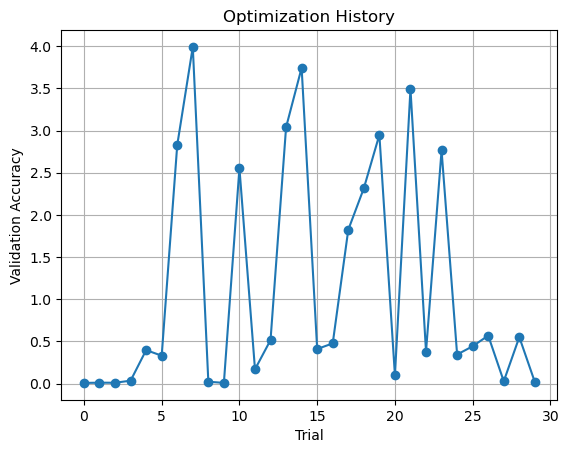

In [9]:

# Plot with custom labels
plt.plot(range(len([t.value for t in study.trials if t.value is not None])), [t.value for t in study.trials if t.value is not None ], marker='o')
plt.xlabel("Trial")
plt.ylabel("Validation Accuracy")
plt.title("Optimization History")
plt.grid(True)

In [10]:
optuna.visualization.plot_parallel_coordinate(study, target_name='Accuracy').show()
optuna.visualization.plot_slice(study, target_name='Accuracy').show()

[W 2025-08-12 22:19:33,399] Your study has only completed trials with missing parameters.


In [11]:
optuna.visualization.plot_contour(study, target_name = 'Accuracy').show()
optuna.visualization.plot_edf(study, target_name = 'Accuracy').show()

In [12]:
optuna.visualization.plot_intermediate_values(study).show()
optuna.visualization.plot_rank(study, target_name = 'Accuracy').show()

C:\Users\chihp\AppData\Local\Temp\ipykernel_15316\2170925048.py:2: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [ ]:
optuna.visualization.plot_timeline(study).show()

C:\Users\chihp\AppData\Local\Temp\ipykernel_15316\2665817185.py:1: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.



: 